## Packages

In [2]:
import pandas as pd
import json, requests 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

import time

import unicodedata
#from metaphone import doublemetaphone
#from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
import re


from math import radians, cos, sin, asin, sqrt

import datetime 
from datetime import date

import psycopg2


In [3]:
main_path = "/home/fs01/spec1142/Emma/PPPs/"

In [4]:
dic_institutions = pd.read_csv(main_path + "institutions_up_to_20230817.tsv" , delimiter = "\t", index_col = 0).to_dict("index")

In [8]:
## import predictive model trained using self-plagiarism
import pickle
with open(main_path + 'random_forest_PPPs.pkl','rb') as f:
    rf = pickle.load(f)
    

## Functions 

In [9]:
def clean_encoding(encoded_text):
    if encoded_text == None:
        return None
    else:
        if "\n" in encoded_text:
            encoded_text = encoded_text.replace("\n" , "")
        encoded_text = encoded_text[1:-1]
        encoded_text = list(map(float , encoded_text.split()))
        return encoded_text

In [10]:
name_del = set(["2nd", "3rd", "Jr", "Jr.", "Junior", "Sr", "Sr.", "Senior"])
ln_suff= set(["oster", "nordre", "vaster", "aust", "vesle", "da", "van t", "af", "al", "setya", "zu", "la", "na", "mic", "ofver", "el", "vetle", "van het", "dos", "ui", "vest", "ab", "vste", "nord", "van der", "bin", "ibn", "war", "fitz", "alam", "di", "erch", "fetch", "nga", "ka", "soder", "lille", "upp", "ua", "te", "ni", "bint", "von und zu", "vast", "vestre", "over", "syd", "mac", "nin", "nic", "putri", "bet", "verch", "norr", "bath", "della", "van", "ben", "du", "stor", "das", "neder", "abu", "degli", "vre", "ait", "ny", "opp", "pour", "kil", "der", "oz",  "von", "at", "nedre", "van den", "setia", "ap", "gil", "myljom", "van de", "stre", "dele", "mck", "de", "mellom", "mhic", "binti", "ath", "binte", "snder", "sre", "ned", "ter", "bar", "le", "mala", "ost", "syndre", "sr", "bat", "sndre", "austre", "putra", "putera", "av", "lu", "vetch", "ver", "puteri", "mc", "tre", "st"])


#suppress all the unwanted suffixes from a string. 
#name_del file can be modified if more or less suffixes want to be suppressed 


def name_delete(string):
    for elmt in name_del:
        if f" {elmt}" in string:
            string =  string.replace(f" {elmt}","")
    return string


#merge the nobiliary particles with the last name
#ln_suff file can be modified if more or less nobiliary particles want to be suppressed
    
def ln_suff_merge(string):
    for suff in ln_suff:
        if f"{' ' + suff + ' '}" in string or string.startswith(f"{suff + ' '}"):
            print(suff)
            string =  string.replace(f"{suff + ' '}", suff.replace(" ",""))
    return string



In [11]:
#normalize a string dat that represents often a name. 

def normalize(data):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    # delete unwanted elmt
    val = name_delete(val)
    # Lower case
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove trailing spaces
    val = val.strip()
    return val

normalize("PIERRE De BEHRMAN")

'pierre de behrman'

In [12]:
## calculate efficiently the dot product between two vectors

def norm(vector):
    return sqrt(sum(x * x for x in vector))    

def cosine_similarity2(vec_a, vec_b):
    norm_a = norm(vec_a)
    norm_b = norm(vec_b)
        
        
    if norm_a == 0 or norm_b == 0 :
        return None 
    
    else:
        dot = sum(a * b for a, b in zip(vec_a, vec_b))
        return dot / (norm_a * norm_b)

In [13]:
#return a ratio of similarity of letters between two strings (to handle in the first names errors)

def match_ratio(string1,string2):
    return fuzz.ratio(string1, string2)


In [14]:
#return 4 if string1 and string2 are the same
#return 3 if string1 and string2 sound the same
#otherwise, return less

def metaphone(string1,string2):
    if string1==string2:
        return 4
    tuple1 = doublemetaphone(string1)
    tuple2 = doublemetaphone(string2)
    if tuple1[0] == tuple2[0]:
        return 3
    elif tuple1[0] == tuple2[1] or tuple1[1] == tuple2[0]:
        return 2
    elif tuple1[1] == tuple2[1]:
        return 1
    else:
        return 0

In [15]:
## return 1 if name1 and name2 potentially represent the same individual
## else return 0

def comparison(name1 , name2):
    
    #if there is no first name, retrun it's a match
    if name1 == "" or name2 == "":
        return 1
    
    #if some first names exist:
    list_name1 = name1.split()
    list_name2 = name2.split()
    
    #minimum number of first names to match
    number_match = min( len(list_name1) , len(list_name2))
    
    #for each name, check if there is a match
    count_match = 0
    for elem1 in list_name1:
        match = 0
        
        #if we just have the initial:
        if len(elem1) == 1:
            for elem2 in list_name2:
                if elem1[0] == elem2[0]:
                    match = 1
        else:
            for elem2 in list_name2:
                #if we just have the initial:
                if len(elem2) == 1 and elem1[0] == elem2[0]:
                    match = 1
                    
                #if elem1 and elem2 are entire first names that sound the same and have a ratio of common letters higher thsan 85%, it's a match
                elif len(elem2) > 1 and (metaphone(elem1,elem2) > 2 or match_ratio(elem1 , elem2) > 85 ) :
                    match = 1
                    
        #count the number of first names that match    
        count_match += match
        
    #check if we have enough first names that match 
    if count_match < number_match:
        return 0
    else:
        return 1



In [16]:
## get number of in common authors

def number_of_in_common_authors(inventors , authors ):
    

    
    #count the number of names in common, and store the names in common
    count = 0
    list_in_common_authors = []

    
    for name_inventor in inventors:
        
        for name_author in authors:
                        
            
            if len(set(name_inventor.split()) & set( name_author.split())) > 0:
            
                match = comparison(name_author , name_inventor)

                #if the first names match, we store the first names that are matching and their index 
                if match == 1:
                    count += 1 
                    list_in_common_authors.append(name_author + "-" + name_inventor)
                    


    #return 1) the number of names in common, 2) the list of names in common, 3) their index 
    return  count ,  list_in_common_authors 


In [17]:
## calculate efficiently the geographic distance between two points on the earth

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [18]:
def distance_assignees(coords1 , coords2):
     
    distance = np.inf
    #get minimum geographic distance between the paper and the patent institutions
    for elem1 in coords1:
        if elem1 in coords2:
            return 0
        else:
            for elem2 in coords2:
                dist = haversine(elem1[0], elem1[1], elem2[0], elem2[1])
                if dist < distance:
                    distance = dist
                    
    if distance == np.inf:
        distance = None
                    
    return distance
        

In [19]:
##function that compare a patent and a paper and create the features that will be used as input of the predictive model
def paper_patent_comparison(patent_id , paper_id , dic_comparison):

    
    ##the features are stored as a dictionay in the input dictonary
    dic_comparison["comparisons"][patent_id][paper_id] = {}
    
    ##compare the title and the abstract with by taking the cosinus of the numerical representations of the text
    title_OA = dic_comparison["OA"][paper_id]["title"]
    title_PV = dic_comparison["PV"][patent_id]["title"]
    abstract_OA = dic_comparison["OA"][paper_id]["abstract"]
    abstract_PV = dic_comparison["PV"][patent_id]["abstract"]
    
    if title_OA != None and title_PV != None:
        dic_comparison["comparisons"][patent_id][paper_id]["title_similarity"] = cosine_similarity2( title_OA , title_PV ) 
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["title_similarity"] = None
        
    if abstract_PV != None and abstract_OA != None:
        dic_comparison["comparisons"][patent_id][paper_id]["abstract_similarity"] = cosine_similarity2( abstract_PV , abstract_OA ) 
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["abstract_similarity"] = None
        
        
    ##calucate the difference (in days) between the patent grant date and the paper publication date
    if   dic_comparison["OA"][paper_id]["publication_date"] != None and dic_comparison["PV"][patent_id]["patent_date"] != None and dic_comparison["PV"][patent_id]["patent_date"]!= '':
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_grant_paper"] =   (dic_comparison["PV"][patent_id]["patent_date"] - dic_comparison["OA"][paper_id]["publication_date"] ).days
        
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_grant_paper"] = None
     
    
    ##calucate the difference (in days) between the patent application date and the paper publication date
    if dic_comparison["OA"][paper_id]["publication_date"] != None and dic_comparison["PV"][patent_id]["filing_date"] != None:
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper"] =  (dic_comparison["PV"][patent_id]["filing_date"] - dic_comparison["OA"][paper_id]["publication_date"]).days
    else:
        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper"] = None
        
        
        
    ##store the paper's type (article, book-chapter etc...) 
    dic_comparison["comparisons"][patent_id][paper_id]["paper type"] = dic_comparison["OA"][paper_id]["type"]  
    
    ##count the number of author's name in common between the paper and the patent 
    dic_comparison["comparisons"][patent_id][paper_id]["authors in common"] = number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][paper_id]["co_authors"])[0]
    
    ##calculate what proportion of the patent inventors the number of author's name in common represents 
    dic_comparison["comparisons"][patent_id][paper_id]["proportion inventors"] = 100*number_of_in_common_authors(dic_comparison["PV"][patent_id]["co_inventors"] , dic_comparison["OA"][paper_id]["co_authors"])[0] / len(dic_comparison["PV"][patent_id]["co_inventors"])
    
    ##calculate the (minimal) geographic distance between the patent assignee and the paper institution (in km)
    dic_comparison["comparisons"][patent_id][paper_id]["distance_inst_assignee"] = distance_assignees(dic_comparison["PV"][patent_id]["coordinates"], dic_comparison["OA"][paper_id]["coordinates"] )
  
    ##return the updated dic_comparison
    return dic_comparison
        
        


## PPPs

In [20]:
df_gatekeepers = pd.read_csv(main_path + "gatekeepers_clean_v2.tsv", delimiter = "\t")

In [21]:
data = df_gatekeepers[["inventor_id" , "author_id"]].to_numpy()

clusters = []
G = nx.Graph()
G.add_edges_from(data)
count = 0 
for connected_component in nx.connected_components(G):
    clusters.append(connected_component)
    
print("Number of gatekeepers:" , len(clusters))


Number of gatekeepers: 904554


In [22]:
dic_clusters = {}
count = 0 

for cluster in tqdm(clusters):
    dic_clusters[count] = {}
    dic_clusters[count]["OA"] = []
    dic_clusters[count]["PV"] = []
    for elem in cluster:
        
        if elem[0] == "A":
            dic_clusters[count]["OA"].append(   elem  )
        else:
            dic_clusters[count]["PV"].append( elem )
        
    count += 1
    
    

100%|███████████████████████████████| 904554/904554 [00:06<00:00, 135301.34it/s]


In [36]:
def PPPs_GK(i):
    
    #establishing the connection
    conn = psycopg2.connect("user=spec1142 password=VgEpfFtDhXIU")
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
        
    ##number of gatekeeper to analyse 
    size = len(dic_clusters)
    ##new output file: will store the potential PPPs. 
    dic_features = {}
    
    ##count the number of iteration realized - dic_features will be saved at 100 iterations 
    k = 0
    
    for count in range(1):
            
            k += 1 
            count= 4118
            
        #try:
            
            
            ##dic_comparison stores all the papers (key: "OA"), patents data (key: "PV") and comparison between papers and patents ("comparisons")  corresponding the gatekeeper
            dic_comparison = {}
            dic_comparison["PV"] = {}
            dic_comparison["OA"] = {}
            dic_comparison["comparisons"] = {}


            ##query the papers corresponding to the author id
            ##paper_ids stores the papers written by the gatekeepers
            paper_ids  = set()
            for author_id in dic_clusters[count]["OA"]:

                new_paper_ids  = set()

                text = """ SELECT work_id
                            FROM works_authors_OpenAlex 
                            WHERE author_id = '""" + author_id + """';"""

                cursor.execute(text)
                res = cursor.fetchall()

                for line in res:
                    new_paper_ids.add(line[0])
                paper_ids = paper_ids.union(new_paper_ids)

            
            ##query the patents corresponding to the inventor id
            ##patent_ids stores the patents written by the gatekeepers
            patent_ids = set()
            for inventor_id in dic_clusters[count]["PV"]:

                new_patent_ids  = set()


                text = """ SELECT patent_id
                            FROM inventors_PatentsView  
                            WHERE inventor_id = '""" + inventor_id + """';"""

                cursor.execute(text)  
                res = cursor.fetchall()

                for line in res:
                    new_patent_ids.add(line[0])

                    patent_ids = patent_ids.union(new_patent_ids)


            

            ##query the patents data, and store the data in dic_comparison["PV"]
            for patent_id in patent_ids:

                dic_comparison_new = {}
        

                ##query the patents data, and store the data in dic_comparison["PV"]
                dic_comparison_new = {}
                
                text = """ SELECT   p.patent_date , 
                                    ap.filing_date , 
                                    string_agg( CONCAT(disambig_inventor_name_first , ' ' , disambig_inventor_name_last  ) , '#') , 
                                    pe.encoded_title , 
                                    pe.encoded_abstract , 
                                    string_agg( CONCAT(a.disambig_assignee_organization  , '%' , l.longitude , '%' , l.latitude)  , '#')
                            FROM patents_PatentsView AS p 
                            JOIN applications_PatentsView AS ap ON ap.patent_id = p.patent_id
                            JOIN inventors_PatentsView AS i ON i.patent_id =  p.patent_id
                            JOIN assignees_PatentsView AS a ON a.patent_id =  p.patent_id
                            JOIN locations_PatentsView AS l ON a.location_id = l.location_id
                            JOIN encoded_patents_PatentsView AS pe ON pe.patent_id = p.patent_id
                            WHERE p.patent_id = '""" + patent_id  + """'
                            GROUP BY p.patent_date , 
                                    ap.filing_date , 
                                    pe.encoded_title , 
                                    pe.encoded_abstract ;"""
                        
                cursor.execute(text)
                res = cursor.fetchall()
                
                for line in res:
                    dic_comparison_new["patent_date"] = line[0]
                    dic_comparison_new["filing_date"] = line[1]
                    if line[2] != None:
                        dic_comparison_new["co_inventors"] = [ normalize(elem) for elem in set(line[2].split("#")) ] 
                    else:
                        dic_comparison_new["co_inventors"] = []
                    if line[3] != None:
                        dic_comparison_new["title"] = clean_encoding(line[3])
                    else:
                        
                        dic_comparison_new["title"] = None
                    if line[4] != None:
                        dic_comparison_new["abstract"] = clean_encoding(line[4])
                    if line[5] != None:
                        locations = [ elem.split("%") for elem in set(line[5].split("#"))] 
                        dic_comparison_new["assignees"] = ", ".join([ elem[0] for elem in locations])
                        dic_comparison_new["coordinates"] = [ (float(elem[1]) , float(elem[2]))for elem in locations if len(elem) > 2 ]
                    else:
                        dic_comparison_new["assignees"] = None
                        dic_comparison_new["coordinates"] = []
                dic_comparison["PV"][patent_id] = dic_comparison_new


        
            ##query papers data and store the data in dic_comparison["OA"]
            for paper_id in paper_ids:


                dic_comparison_new = {}
                ##query papers data and store the data in dic_comparison["OA"]
                dic_comparison_new = {}
                text = """ SELECT   we.encoded_title , 
                            we.encoded_abstract , 
                            w.publication_date , 
                            w.type , 
                            string_agg(a.display_name , '#') , 
                            string_agg(wa.institution_name , '#') , 
                            string_agg(wa.institution_id , '#'),
                            w.doi
            
                        
                   FROM works_authors_OpenAlex AS wa
                   JOIN works_OpenAlex AS w ON w.work_id = wa.work_id
                   JOIN authors_OpenAlex AS a ON wa.author_id = a.author_id
                   JOIN encoded_works_OpenAlex AS we ON we.work_id = wa.work_id
                   WHERE wa.work_id =  '""" + paper_id + """'
                   GROUP BY we.encoded_title , 
                            we.encoded_abstract , 
                            w.publication_date , 
                            w.type,
                            w.doi;"""
                
                cursor.execute(text)
                res = cursor.fetchall()
                
                for line in res:
                    
                    try:
                        dic_comparison_new["title"]  = clean_encoding(line[0])
                    except: 
                        dic_comparison_new["title"] = None

                    try: 
                        dic_comparison_new["abstract"]  = clean_encoding(line[1])
                    except: 
                        dic_comparison_new["abstract"] = None
                    dic_comparison_new["publication_date"] = line[2]
                    dic_comparison_new["type"] = line[3]
                    dic_comparison_new["co_authors"] = [ normalize(elem) for elem in set(line[4].split("#") )] 
            
                    dic_comparison_new["institutions"] = set()
                    if line[5] != None:
                        dic_comparison_new["institutions"] = set( line[5].split("#") )
                        
                    if line[6] != None:
                        inst_ids = set(line[6].split("#"))
                    else:
                        inst_ids = []
                        
                    dic_comparison_new["coordinates"] = []
                    for inst_id in inst_ids:
                            if inst_id in dic_institutions:
                                dic_comparison_new["coordinates"].append((dic_institutions[inst_id]["longitude"] , dic_institutions[inst_id]["latitude"]))
                                dic_comparison_new["institutions"].union(dic_institutions[inst_id]["display_name"])
                    dic_comparison_new["institutions"] = "; ".join(list(dic_comparison_new["institutions"]))

                    dic_comparison_new["doi"] = line[7]
            
                
                dic_comparison["OA"][paper_id]  = dic_comparison_new



            for patent_id in patent_ids:
                ##compare all the patents and papers together
                dic_comparison["comparisons"][patent_id] = {}
                for paper_id in paper_ids:

                    ##compare patent_id with paper_id
                    if dic_comparison["OA"][paper_id] != {} and dic_comparison["PV"][patent_id] != {}:
                        dic_comparison = paper_patent_comparison(patent_id , paper_id , dic_comparison)
                        
                if len(dic_comparison["comparisons"][patent_id]) > 0:
                    table = pd.DataFrame(dic_comparison["comparisons"][patent_id]).T[['title_similarity', 'abstract_similarity', 'authors in common', 'proportion inventors','distance_inst_assignee']]
                    
                    ##if the distance is missing (if the assignee or institution location is missing) 
                    ##replace the missing value with the average distance between the papers and the patents
                    mean = table["distance_inst_assignee"].mean()
                    table["distance_inst_assignee"] = table["distance_inst_assignee"].fillna(mean)
                    
                    ##drop all the papers and patents comparison with missing values (abstract, title, etc...)
                    table = table.dropna()
                    
                    ##predict if the patents and papers are PPPs
                    if len(table) > 0:
                
                        table["predictions"] = rf.predict_proba(table)[:,1]
                        
                        ##keep only keep the prediction higher than 0.2 and the highest prediction (with a precision of 0.05)
                        max_pred = max(table["predictions"])
                        PPPs_paper_ids = table[ ( table["predictions"] > max_pred - 0.05 ) &  ( table["predictions"] > 0.7 )][["predictions"]].to_dict("index")
                        
                        ##write the selected PPPs in the output file dic_features 
                        for paper_id in PPPs_paper_ids:
                                dic_features[paper_id + " US-" + patent_id] = dic_comparison["comparisons"][patent_id][paper_id]
                                dic_features[paper_id + " US-" + patent_id]["paper_id"] = paper_id
                                dic_features[paper_id + " US-" + patent_id]["patent_id"] = patent_id
                                dic_features[paper_id + " US-" + patent_id]["doi"] = dic_comparison["OA"][paper_id]["doi"]
                                dic_features[paper_id + " US-" + patent_id]["prediction"] = PPPs_paper_ids[paper_id]["predictions"]
            
        #except:
            #file_error = main_path + "PPPs_GK/errors"
            ##file_object = open(file_error, 'a')
            #file_object.write(paper_id + " US-" + patent_id + "\n")
            #file_object.close()
            #continue
            #print(count)

        ##save the output every 1000 iterations.
        #if k % 1000 == 0:
    
            #res = pd.DataFrame(dic_features).T
            #res.to_csv(main_path + "PPPs_GK/table_pred_" + str(i) + ".tsv"  , sep = "\t")
            
    #Closing the connection
    conn.close() 


    ##save the file as a tsv file
    res = pd.DataFrame(dic_features).T
    #res.to_csv(main_path + "PPPs_GK/table_pred_" + str(i) + ".tsv" , sep = "\t" )

    return res   



In [37]:
res = PPPs_GK(0)

ValueError: could not convert string to float: 'a'

In [35]:
res

""


In [34]:
#run the code using 32 CPUs   
import warnings    
from multiprocessing import Process

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=PPPs_citations, args=(k,)) for k in range(32)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()

In [ ]:
def PPPs_gatekeepers(i):
    
    ##connect to the database 
    mydb = mysql.connector.connect(user='openalex', password='_OpenAlex_',
                                          host='haas-hpc11',
                                          database='openalex')
    mycursor = mydb.cursor()

    ##number of gatekeeper to analyse 
    size = len(dic_cluster)
    ##new output file: will store the potential PPPs. 
    dic_features = {}
    
    ##count the number of iteration realized - dic_features will be saved at 100 iterations 
    k = 0

    for count in range(i,size,32):
        
        k += 1 
        
        try:
            
            
            ##dic_comparison stores all the papers (key: "OA"), patents data (key: "PV") and comparison between papers and patents ("comparisons")  corresponding the gatekeeper
            dic_comparison = {}
            dic_comparison["PV"] = {}
            dic_comparison["OA"] = {}
            dic_comparison["comparisons"] = {}


            ##query the papers corresponding to the author id
            ##paper_ids stores the papers written by the gatekeepers
            paper_ids  = set()
            for author_id in dic_cluster[count]["OA"]:

                new_paper_ids  = set()

                text = """ SELECT work_id
                            FROM works_authors_OpenAlex 
                            WHERE author_id = '""" + author_id + """';"""

                mycursor.execute(text)  
                res = mycursor.fetchall()

                for line in res:
                    new_paper_ids.add(line[0][21:])
                paper_ids = paper_ids.union(new_paper_ids)


            ##query the patents corresponding to the inventor id
            ##patent_ids stores the patents written by the gatekeepers
            patent_ids = set()
            for inventor_id in dic_cluster[count]["PV"]:

                new_patent_ids  = set()


                text = """ SELECT patent_id
                            FROM inventors_PatentsView  
                            WHERE inventor_id = '""" + inventor_id + """';"""

                mycursor.execute(text)  
                res = mycursor.fetchall()

                for line in res:
                    new_patent_ids.add(line[0])

                    patent_ids = patent_ids.union(new_patent_ids)



            ##query the patents data, and store the data in dic_comparison["PV"]
            for patent_id in patent_ids:

                dic_comparison_new = {}

                text = """ SELECT  p.patent_date , 
                                   ap.filing_date , 
                                   GROUP_CONCAT(disambig_inventor_name_first , " " , disambig_inventor_name_last SEPARATOR '#') , 
                                   pe.encoded_title , 
                                   pe.encoded_abstract , 
                                   GROUP_CONCAT(a.disambig_assignee_organization  , '%' , l.longitude , '%' , l.latitude SEPARATOR '#')

                            FROM patents_PatentsView AS p 
                            LEFT JOIN applications_PatentsView AS ap ON ap.patent_id = '"""+ patent_id+ """'
                            LEFT JOIN inventors_PatentsView AS i ON i.patent_id =  '"""+ patent_id+ """'
                            LEFT JOIN assignees_PatentsView AS a ON a.patent_id =  '""" + "\"" + patent_id + "\"" + """'
                            LEFT JOIN locations_PatentsView AS l ON a.location_id = l.location_id
                            LEFT JOIN patents_encoded_PatentsView AS pe ON pe.patent_id = '"""+ patent_id+ """'

                            WHERE p.patent_id = '"""+  "\"" + patent_id  + "\"" + """';"""

                mycursor.execute(text)  

                res = mycursor.fetchall()

                for line in res:
                    dic_comparison_new["patent_date"] = line[0]
                    dic_comparison_new["filing_date"] = line[1]
                    dic_comparison_new["co_inventors"] = [ normalize(elem) for elem in set(line[2].split("#")) ] 

                    if line[0] != 0:
                        dic_comparison_new["title"] = clean_encoding(line[3])
                    if line[1] != 0:
                        dic_comparison_new["abstract"] = clean_encoding(line[4])


                    if line[5] != None:
                        locations = [ elem.split("%") for elem in set(line[5].split("#"))] 
                        dic_comparison_new["assignees"] = ", ".join([ elem[0].replace("\"" , "") for elem in locations ] )
                        dic_comparison_new["coordinates"] = [ (float(elem[1]) , float(elem[2]))for elem in locations if len(elem) > 2 ]
                    else:
                        dic_comparison_new["assignees"] = None
                        dic_comparison_new["coordinates"] = []



                dic_comparison["PV"][patent_id] = dic_comparison_new



            ##query papers data and store the data in dic_comparison["OA"]
            for paper_id in paper_ids:


                dic_comparison_new = {}

                text = """ SELECT   we.title_encoded , 
                                    we.abstract_encoded , 
                                    w.publication_date , 
                                    w.type , 
                                    GROUP_CONCAT(a.display_name SEPARATOR '#') , 
                                    GROUP_CONCAT(wa.institution_name SEPARATOR '#tab#') , 
                                    GROUP_CONCAT(wa.institution_id SEPARATOR '#tab#')

                            FROM works_authors_OpenAlex AS wa
                            LEFT JOIN ( SELECT work_id , publication_date , type FROM works_OpenAlex WHERE work_id = '""" + str(paper_id) + """'
                                        UNION 
                                        SELECT work_id , publication_date , type FROM works_OpenAlex3 WHERE work_id = '""" + str(paper_id) + """') AS w ON w.work_id = SUBSTRING(wa.work_id , 22 , 20)
                            LEFT JOIN authors_OpenAlex AS a ON wa.author_id = a.author_id
                            LEFT JOIN works_encoded_OpenAlex AS we ON we.work_id = '""" + str(paper_id) + """'

                            WHERE wa.work_id = 'https://openalex.org/"""+ str(paper_id) +"""';"""

                mycursor.execute(text)  
                res = mycursor.fetchall()

                for line in res:

                    try:
                        dic_comparison_new["title"]  = clean_encoding(line[0])
                    except: 
                        dic_comparison_new["title"] = None
                    try: 
                        dic_comparison_new["abstract"]  = clean_encoding(line[1])
                    except: 
                        dic_comparison_new["abstract"] = None
                    dic_comparison_new["publication_date"] = line[2]
                    dic_comparison_new["type"] = line[3]
                    dic_comparison_new["co_authors"] = [ normalize(elem) for elem in set(line[4].split("#") )] 
                    dic_comparison_new["institutions"] = "; ".join(list(set( line[5].replace("\r" , "").split("#tab#") )))

                    inst_ids = set(line[6].split("#tab#"))

                    dic_comparison_new["coordinates"] = []
                    for inst_id in inst_ids:
                        if inst_id in dic_institutions:
                            dic_comparison_new["coordinates"].append((dic_institutions[inst_id]["longitude"] , dic_institutions[inst_id]["latitude"]))

                dic_comparison["OA"][paper_id]  = dic_comparison_new



#            ##get the oldest data of the patent family
#            for patent_id in patent_ids:
#
#
#                dic_parents_patents = {}
#                patent = "US-" + str(patent_id)
#                dic_parents_patents[patent] = {}
#
#                text = """ SELECT p.parent_application_number, a2.patent_number,  a.application_number , a.patent_number , p.parent_filing_date
#                           FROM applications2_PatentsView AS a
#                           LEFT JOIN parents_PatentsView AS p ON a.application_number = p.application_number
#                           LEFT JOIN applications2_PatentsView AS a2 ON a2.application_number = p.parent_application_number
#                           WHERE a.patent_number = '""" + str(patent_id) + """';
#                           """
#
#                mycursor.execute(text)  
#                res = mycursor.fetchall()
#
#                for line in res:
#
#                    if "parents_applications_or_granted" not in dic_parents_patents[patent]:
#                        dic_parents_patents[patent]["parents_applications_or_granted"] = []
#                        dic_parents_patents[patent]["parents_applications_or_granted"].append( (line[2] , patent) ) 
#
#                    if line[1] != None and line[1] != '':
#                        dic_parents_patents[patent]["parents_applications_or_granted"].append( ( "US-" + str(line[1]) , patent ))
#
#                    if line[0] != None and line[0] != '':   
#                        dic_parents_patents[patent]["parents_applications_or_granted"].append(( line[0] , patent ))
#
#                    if line[4] != None and line[4] != '':
#                        if "filling_date" not in dic_parents_patents[patent]  or line[4] < dic_parents_patents[patent]["filling_date"][-1] :
#
#                            if line[1] == '' or line[1] == None:
#                                dic_parents_patents[patent]["filling_date"] = ( line[0], line[1] , line[4] )
#                            else:
#                                dic_parents_patents[patent]["filling_date"] = ( line[0], "US-" + str(line[1]) , line[4] )
#
#                if  "filling_date" in dic_parents_patents[patent]:
#                     filling_date = ( dic_parents_patents[patent]["filling_date"][0] , dic_parents_patents[patent]["filling_date"][1] , dic_parents_patents[patent]["filling_date"][-1].isoformat())
#
#                else:
#                    filling_date = None
#



                ##compare all the patents and papers together
                dic_comparison["comparisons"][patent_id] = {}

                for paper_id in paper_ids:

                    ##compare patent_id with paper_id
                    dic_comparison = paper_patent_comparison(patent_id , paper_id , dic_comparison)

#                    if filling_date != None and dic_comparison["OA"][paper_id]["publication_date"] != None:
#                        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper_real"] =  (date.fromisoformat(filling_date[-1]) - dic_comparison["OA"][paper_id]["publication_date"]).days
#                    else:
#                        dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper_real"]  = dic_comparison["comparisons"][patent_id][paper_id]["difference_patent_app_paper"] 

                table = pd.DataFrame(dic_comparison["comparisons"][patent_id]).T[['titles', 'abstract', 'authors in common', 'proportion inventors','distance_inst_assignee']]

                ##if the distance is missing (if the assignee or institution location is missing) 
                ##replace the missing value with the average distance between the papers and the patents
                mean = table["distance_inst_assignee"].mean()
                table["distance_inst_assignee"] = table["distance_inst_assignee"].fillna(mean)
                
                ##drop all the papers and patents comparison with missing values (abstract, title, etc...)
                table = table.dropna()
                
                
                ##predict if the patents and papers are PPPs
                if len(table) > 0:
                    table["predictions"] = rf.predict_proba(table)[:,1]
                    
                    
                    ##keep only keep the prediction higher than 0.2 and the highest prediction (with a precision of 0.05)
                    max_pred = max(table["predictions"])
                    PPPs_paper_ids = table[ ( table["predictions"] > max_pred - 0.05 ) &  ( table["predictions"] > 0.2 )][["predictions"]].to_dict("index")

                    ##write the selected PPPs in the output file dic_features 
                    for paper_id in PPPs_paper_ids:

                        dic_features[paper_id + " US-" + patent_id] = dic_comparison["comparisons"][patent_id][paper_id]
                        dic_features[paper_id + " US-" + patent_id]["paper_id"] = paper_id
                        dic_features[paper_id + " US-" + patent_id]["patent_id"] = patent_id
                        dic_features[paper_id + " US-" + patent_id]["prediction"] = PPPs_paper_ids[paper_id]["predictions"]


        ##if an error occurs, write the paper and patent ids in the file errors
        except:
            file_error = "/home/emma_scharfmann/LeeFleming/Matt/PPPs_GateKeepers/errors"
            file_object = open(file_error, 'a')
            file_object.write(paper_id + " US-" + patent_id + "\n")
            file_object.close()
            
            
        ##save the output every 100 iterations.
        if k % 100 == 0:

            res = pd.DataFrame(dic_features).T
            res.to_csv("/home/emma_scharfmann/LeeFleming/Matt/PPPs_GateKeepers/table_pred_v1_" + str(i) + ".tsv"  , sep = "\t")


    
    ##save the file as a tsv file
    res = pd.DataFrame(dic_features).T
    res.to_csv("/home/emma_scharfmann/LeeFleming/Matt/PPPs_GateKeepers/table_pred_v1_" + str(i) + ".tsv" , sep = "\t" )


    mydb.close()     
    

## Results

#### Load PPPs

res = pd.concat( [ pd.read_csv(main_path + "PPPs_GK/table_pred_" + str(i) + ".tsv"  , delimiter = "\t", index_col = 0  ) for i in range(336) ]) 


res.to_csv(main_path + "PPPs_GK/table_pred.tsv"  , sep = "\t" ) 

In [33]:
res = pd.read_csv(main_path + "PPPs_GK/table_pred.tsv" , delimiter = "\t" , index_col = 0  )

In [34]:
res = res.drop_duplicates(["paper_id" , "patent_id"])

In [35]:
res

,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,patent_id,doi,prediction
W4230776453 US-9053919,1.000000,0.742519,3265,165,article,6,100.000000,1.954428,W4230776453,9053919,10.1016/j.jasms.2006.02.009,0.947119
W2133348390 US-7358347,0.722387,0.659401,1475,-2220,article,6,46.153846,12.479383,W2133348390,7358347,10.1196/annals.1294.020,0.934099
W2114546531 US-7358347,0.654039,0.607773,3774,79,article,13,100.000000,13.030851,W2114546531,7358347,NaN,0.927983
W2075173469 US-7358347,0.697149,0.610430,3211,-484,article,13,100.000000,12.479383,W2075173469,7358347,10.1016/s8756-3282(99)00112-x,0.931210
W2087451891 US-7358347,0.791079,0.637815,3842,147,article,13,100.000000,11.319638,W2087451891,7358347,10.1007/s004390050595,0.957690
...,...,...,...,...,...,...,...,...,...,...,...,...
W1984217860 US-8338449,0.586923,0.633474,2251,1253,article,3,50.000000,91.257918,W1984217860,8338449,10.1021/jm060927v,0.754590
W2898074496 US-9340622,0.512992,0.677645,-877,-2584,article,3,75.000000,147.932811,W2898074496,9340622,10.1186/s12967-018-1653-x,0.949841
W2566924442 US-10933122,0.766236,0.436886,1537,951,article,2,66.666667,1.368140,W2566924442,10933122,10.1038/srep35598,0.834153
W2566924442 US-9764008,0.766236,0.436886,277,-1317,article,2,66.666667,1.368140,W2566924442,9764008,10.1038/srep35598,0.834153


#### PPP score

In [36]:
res["PPP_score"] = [ 4 if elem > 0.99 else 3 if elem > 0.9 else 2 if elem > 0.8 else 1 for elem in res["prediction"] ] 

#### Concepts and Paper institutions and types

In [12]:
import re 

print(len( set(res["paper_id"].tolist())))

list_papers_id = list(set(res["paper_id"].tolist()))

def get_dates(i):
    
    list_papers = [ k for k in range(0 + i , len(list_papers_id) , 28 ) ]

    dic_dates_papers = {}

    #establishing the connection
    conn = psycopg2.connect("user=spec1142 password=VgEpfFtDhXIU")
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()

    for k in list_papers: 
        
        paper = list_papers_id[k]
        
        if paper not in dic_dates_papers:
            dic_dates_papers[paper] = {}
            dic_dates_papers[paper]["institutions"] = set()
            dic_dates_papers[paper]["institution_name"] = set()
            dic_dates_papers[paper]["co_authors"] = []
        

        text = """ SELECT w.publication_date , w.concepts , string_agg(wa.institution_id, ',') , string_agg(wa.author_id , ',') , string_agg(wa.institution_name , '#')
                   FROM works_OpenAlex AS w
                   JOIN works_authors_OpenAlex AS wa ON wa.work_id = '""" + str(paper) + """'
                   WHERE w.work_id = '""" + str(paper) + """'
                   GROUP BY w.work_id , w.publication_date , w.concepts ;
                """

        cursor.execute(text)
        res = cursor.fetchall()
        
        
        if len(res) > 0:
            line = res[0]
            if line[0] != None:
                dic_dates_papers[paper]["publication_date"] = line[0].strftime("%m-%d-%y")
            else:
                dic_dates_papers[paper]["publication_date"] = None
                
            if line[1] != None:
                dic_dates_papers[paper]["concepts"] = line[1].split("; ")
            else:
                dic_dates_papers[paper]["concepts"] = []

            if line[2] != None:
                dic_dates_papers[paper]["institutions"] = list(set(line[2].split(",")))
            else:
                dic_dates_papers[paper]["institutions"]  = []

            if line[3] != None:
                dic_dates_papers[paper]["co_authors"] = list(set(line[3].split(",")))

            
            dic_dates_papers[paper]["institution_name"] = set()
            
            if line[4] != None:
                dic_dates_papers[paper]["institution_name"].add(set(line[4].split("#")))

            for inst in dic_dates_papers[paper]["institutions"]:
                if inst in dic_institutions:
                    dic_dates_papers[paper]["institution_name"].add(dic_institutions[inst]["display_name"])

            dic_dates_papers[paper]["institution_name"]  = list( dic_dates_papers[paper]["institution_name"] )

    conn.close() 

            
    import json
    json = json.dumps(dic_dates_papers)
    f = open(main_path + "PPPs_GK/dic_dates_" + str(i) + ".json","w")
    f.write(json)
    f.close()


    
    


import warnings

        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_dates, args=(k,)) for k in range(28)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()
            
       

342352


In [13]:
dic_dates = {}

for i in range(28):
    
    f = open(main_path + "PPPs_GK/dic_dates_" + str(i) + ".json","r")
    import json
    dic = json.load(f)
    
    dic_dates = { **dic_dates , **dic } 
    

print(len(dic_dates))

342352


In [14]:
import json
json = json.dumps(dic_dates)
f = open(main_path + "PPPs_GK/dic_dates.json","w")
f.write(json)
f.close()


In [37]:
f = open(main_path + "PPPs_GK/dic_dates.json","r")
import json
dic_dates = json.load(f)

In [38]:
res = res.drop_duplicates(["paper_id" , "patent_id"])
dic_PPPs = res.to_dict("index")

ww_institutions = pd.read_csv(main_path + "institutions_up_to_20230817.tsv" , delimiter = "\t" , index_col = 0 )
dic_ww_institutions = ww_institutions.to_dict("index")

main_concepts = set(['Computer science',
 'Medicine',
 'Biology',
 'Physics',
 'Political science',
 'Chemistry',
 'Philosophy',
 'Engineering',
 'Mathematics',
 'Psychology',
 'Materials science',
 'Art',
 'Geography',
 'Business',
 'Sociology',
 'Economics',
 'Geology',
 'History',
 'Environmental science'])

for count in tqdm(list(dic_PPPs.keys())):
    
    paper_id = dic_PPPs[count]["paper_id"]
    if "concepts" in dic_dates[paper_id]:
        concepts = list(set(dic_dates[paper_id]["concepts"]) & main_concepts)
        dic_PPPs[count]["concepts"] = ", ".join(concepts)
    if "institutions" in dic_dates[paper_id]:
        institutions = list(set(dic_dates[paper_id]["institution_name"]))
        dic_PPPs[count]["paper_institution"] = "; ".join(institutions)
        
        types = set()
        for string_inst in dic_dates[paper_id]["institutions"]:
            inst = string_inst.split("#tab#")
            for institution_id in inst:
                if institution_id in dic_ww_institutions:
                    data = dic_ww_institutions[institution_id]
                    if pd.isna(data["type"]) == False and data["type"] != None and data["type"] != 'nan':
                        types.add(data["type"])
        
        dic_PPPs[count]["paper_institutions"] = "; ".join(types)

    
res = pd.DataFrame(dic_PPPs).T   
    

100%|████████████████████████████████| 560919/560919 [00:05<00:00, 99287.48it/s]


#### Patent assignees and types

In [43]:
families = pd.read_csv(main_path + "patent_families.tsv" , delimiter = "\t" , index_col = 0 ) 
dic_patents_families = families.to_dict("index")

In [44]:
workers= 28

PPPs= pd.DataFrame(dic_PPPs).T 

def get_assignee_and_types(i):

    dic_patents = {}

    patents = list(set(PPPs["patent_id"].tolist()))

    index_patents = [ k for k in range(i,len(patents),workers)]
    
    #establishing the connection
    conn = psycopg2.connect("user=spec1142 password=VgEpfFtDhXIU")
    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()


    for k in index_patents:
        
        patent_id = patents[k]

        dic_patents[patent_id] = {}

        dic_patents[patent_id]["type"] = []
        dic_patents[patent_id]["assignee"] = []


        text = """SELECT a.psn_sector , a.han_name
                  FROM ( select publn_nr , appln_id, publn_auth from patent_numbers_Patstat where publn_auth = 'US') AS n
                  JOIN patent_numbers_assignees_Patstat AS p ON p.appln_id = n.appln_id
                  JOIN assignees_PATSTAT AS a ON a.person_id = p.person_id
                  WHERE n.publn_nr = '""" + str(patent_id) + """' 
                  ;"""

        cursor.execute(text)
        res = cursor.fetchall()

        for line in res:

            if line[0] != None and line[0] != '' and line[0] != "INDIVIDUAL" and line[0] != "UNKNOWN":

                dic_patents[patent_id]["type"].append(line[0])
                dic_patents[patent_id]["assignee"].append(line[1])

        
        dic_patents[patent_id]["type"] = "; ".join(list(set(dic_patents[patent_id]["type"])))
        dic_patents[patent_id]["assignee"] = "; ".join(list(set(dic_patents[patent_id]["assignee"])))
        
        dic_patents[patent_id]["assignee_name"] = []
        
        text = """ SELECT disambig_assignee_organization , disambig_assignee_individual_name_last , disambig_assignee_individual_name_first
                    FROM assignees_PatentsView 
                    WHERE patent_id = '""" + str(patent_id) + """';
                    """

        cursor.execute(text)
        res = cursor.fetchall()
        
        for line in res:
            if line[0].replace('"' , '') != '':
                dic_patents[patent_id]["assignee_name"].append(line[0].replace('"' , ''))
            if line[1].replace('"' , '') != '' or line[2].replace('"' , '') :
                dic_patents[patent_id]["assigned_to_individual"] = 1

        
        dic_patents[patent_id]["assignee_name"] = "; ".join(dic_patents[patent_id]["assignee_name"])

        
        text = """ SELECT application_id
                       FROM applications_PatentsView AS a
                       WHERE patent_id = '""" + str(patent_id) + """';
                       """

        cursor.execute(text)
        res = cursor.fetchall()

        for line in res:

            application_number = line[0]

            if application_number in dic_patents_families:
                family = dic_patents_families[application_number]
                dic_patents[patent_id]["family"] = family["family"]
                dic_patents[patent_id]["oldest_date"] = family["oldest_date"]
            else:
                dic_patents[patent_id]["oldest_date"] = None
                dic_patents[patent_id]["family"] = None
            



    table = pd.DataFrame(dic_patents).T
    table.to_csv(main_path + "PPPs_GK/assignee_PV_PPPs_" + str(i) + ".tsv" , sep = "\t")

    conn.close() 

    return table


In [45]:
import warnings

        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_assignee_and_types, args=(k,)) for k in range(28)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()
                        


In [46]:
table_assignees = pd.concat( [ pd.read_csv( main_path + "PPPs_GK/assignee_PV_PPPs_" + str(i) + ".tsv" , delimiter = "\t" , index_col = 0 ) for i in range(28) ] ) 
                              

In [47]:
table_assignees.to_csv( main_path + "PPPs_GK/assignee_PV_PPPs.tsv" , sep = "\t")

In [48]:
table_assignees = pd.read_csv( main_path +  "PPPs_GK/assignee_PV_PPPs.tsv" , delimiter = "\t", index_col = 0 )


In [49]:
table_assignees

,type,assignee,assignee_name,family,oldest_date,assigned_to_individual
6136233,COMPANY,IGEN INT INC,"ATEN INTERNATIONAL CO., LTD.",359838.0,1995-06-07,NaN
8025865,GOV NON-PROFIT,INSTITUTE OF VIROLOGY OF THE SLOVAK ACADEMY OF...,"Institute of Zoology, Slovak Academy of Sciences",934409.0,2002-11-26,NaN
10174099,COMPANY; UNIVERSITY,UCL BUSINESS PLC; AUTOLUS LTD,UCL Business PLC; AUTOLUS LIMITED,3015439.0,2015-12-23,NaN
7235585,COMPANY,CANCER RESEARCH TECH LTD,CANCER RESEARCH TECHNOLOGY LIMITED,1072406.0,2003-09-01,NaN
4842374,COMPANY,HUGHES AIRCRAFT CO,Hughes Aircraft Company,141388.0,1988-09-23,NaN
...,...,...,...,...,...,...
7043435,COMPANY,SBC KNOWLEDGFE VENTURES LP,"SBC KNOWLEDGE VENTURES, L.P.",1192236.0,2004-09-16,NaN
5140530,COMPANY,HONEYWELL INC,Honeywell International Inc.,3901428.0,1991-08-09,NaN
5185750,COMPANY,SPECTRA PHYSICS LASERS INC,"Spectra Physics Lasers, Inc.",190681.0,1990-05-02,NaN
7258859,GOV NON-PROFIT,THE REGENTS OF THE UNIVERSITY OF CALIFORNIA,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",832454.0,2002-06-28,NaN


In [50]:
PPPs= pd.DataFrame(dic_PPPs).T 
PPPs = PPPs.merge(table_assignees[['type', 'assignee_name', 'assigned_to_individual','oldest_date',"family"]] , left_on = "patent_id" , right_index = True, how = "left")
PPPs["assigned_to_individual"]  = PPPs["assigned_to_individual"].fillna(0)
PPPs = PPPs.rename( { "type" : "patent_institutions" , "assignee_name" : "patent_assignee"})

#### Original parents

In [51]:
dic_PPPs = PPPs.to_dict("index")

count = 0
for elem in tqdm(dic_PPPs):
    patent = str(dic_PPPs[elem]["patent_id"])
    paper = dic_PPPs[elem]["paper_id"]
    
    if "publication_date" in dic_dates[paper] and pd.isna(dic_PPPs[elem]["oldest_date"])== False:
        count += 1
        dic_PPPs[elem]["difference_original_patent_app_paper"] = ( datetime.datetime.strptime(dic_PPPs[elem]["oldest_date"], "%Y-%m-%d") - datetime.datetime.strptime(dic_dates[paper]["publication_date"], "%m-%d-%y") ).days 
    else:
        dic_PPPs[elem]["difference_original_patent_app_paper"] = dic_PPPs[elem]["difference_patent_app_paper"]
        

PPPs = pd.DataFrame(dic_PPPs).T

PPPs["difference_original_patent_app_paper"] = PPPs["difference_original_patent_app_paper"].astype("int")
PPPs["difference_patent_app_paper"] = PPPs["difference_patent_app_paper"].astype("int")

PPPs = PPPs[( PPPs["difference_original_patent_app_paper"] < 3000 ) &  (PPPs["difference_original_patent_app_paper"] > -3000)]

100%|████████████████████████████████| 560919/560919 [00:09<00:00, 60784.11it/s]


#### all_patents_for_a_same_paper

In [67]:
import warnings

warnings.filterwarnings("ignore")

dic_same_patents = {} 

from collections import Counter
mylist = [ elem.split()[0] for elem in PPPs.index]
cnt = Counter(mylist)
list_papers = [k for k, v in cnt.items() if v > 1]




def get_similar_patents(i):

    count = 0 
    list_index = [ k for k in range(i,len(list_papers) , 28)]

    
    for k in list_index:
        
        paper_id = list_papers[k]
        matches = PPPs[PPPs["paper_id"] == paper_id]
        
        
        parents = set(matches["family"].tolist())
        if len(parents) == 1  and pd.isna(list(parents)[0]) == False:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same parent"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"]  = "same parent"
        
        if len(set(matches["difference_patent_app_paper"].tolist())) == 1:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same application date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same application date"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same application date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same application date"
        
        
        if len(set(matches["difference_patent_grant_paper"].tolist())) == 1:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same grant date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same grant date"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same grant date"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same grant date"
                    
                            
        if len(set(matches["abstract_similarity"].tolist())) == 1:        
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same abstract"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same abstract"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same abstract"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same abstract"
                    
                    
        if len(set(matches["title_similarity"].tolist())) == 1:
            for elem in matches.index:
                if elem not in dic_same_patents:
                    dic_same_patents[elem] = {} 
                    count += 1
                    #PPPs["all_patents_for_a_same_paper"][elem] = "same title" 
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] =  "same title"
                else:
                    #PPPs["all_patents_for_a_same_paper"][elem] += ", same title"
                    dic_same_patents[elem]["all_patents_for_a_same_paper"] +=  ", same abstract"
                    

    import json
    json = json.dumps(dic_same_patents)
    f = open(main_path + "PPPs_GK/dic_same_patents_" + str(i) + ".json","w")
    f.write(json)
    f.close()
                   


import warnings

        
from multiprocessing import Process


if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",UserWarning)
        
        processes = [Process(target=get_similar_patents, args=(k,)) for k in range(28)]
        
        for process in processes:
            process.start()
            
        for process in processes:
            process.join()
            
      

In [68]:
dic_same_patents = {}

for i in range(28):
    
    f = open(main_path + "PPPs_GK/dic_same_patents_" + str(i) + ".json","r")
    import json
    dic = json.load(f)
    
    dic_same_patents = { **dic_same_patents , **dic } 
    

print(len(dic_same_patents))

133862


In [69]:
import json
json = json.dumps(dic_same_patents)
f = open(main_path + "PPPs_GK/dic_same_patents.json","w")
f.write(json)
f.close()

In [52]:
f = open(main_path + "PPPs_GK/dic_same_patents.json","r")
import json
dic_same_patents = json.load(f)

In [53]:
same_patents = pd.DataFrame(dic_same_patents).T
PPPs = PPPs.merge(same_patents , left_index = True , right_index = True , how = "left")

#### Rename variables 

In [54]:
PPPs = PPPs.reset_index()
PPPs = PPPs.rename( columns = { "index" : "PV_id_OA_id" , "titles" : "title_similarity" , "abstract" : "abstract_similarity" , "type" : "patent_institutions" , "assignee_name" : "patent_assignee" })
PPPs["patent_id"] = [ "US-" + str(elem) for elem in PPPs["patent_id"]]  
PPPs["PPP_score"] = [ 4 if elem > 0.99 else 3 if elem > 0.9 else 2 if elem > 0.8 else 1 if elem > 0.7 else 0  for elem in PPPs["prediction"] ] 
PPPs = PPPs[['PV_id_OA_id', 'title_similarity', 'abstract_similarity',
       'difference_patent_grant_paper', 'difference_patent_app_paper',
       'paper type', 'authors in common', 'proportion inventors',
       'distance_inst_assignee', 'paper_id', 'patent_id', 'prediction',
       'PPP_score', 'concepts', 'paper_institution', 'paper_institutions',
       'patent_institutions', 'patent_assignee', 'assigned_to_individual',
       'difference_original_patent_app_paper', 'all_patents_for_a_same_paper',"family"]]
PPPs = PPPs[ (PPPs["difference_original_patent_app_paper"] < 3000 ) & (PPPs["difference_original_patent_app_paper"] > -3000)]

In [55]:
PPPs

,PV_id_OA_id,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,...,PPP_score,concepts,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,difference_original_patent_app_paper,all_patents_for_a_same_paper,family
0,W4230776453 US-9053919,1.0,0.742519,3265,165,article,6,100.0,1.954428,W4230776453,...,3,"Physics, Engineering, Chemistry",Highland Community College - Illinois; Brigham...,education,UNIVERSITY,Brigham Young University,0.0,-200,NaN,1296822.0
1,W2133348390 US-7358347,0.722387,0.659401,1475,-2220,article,6,46.153846,12.479383,W2133348390,...,3,"Biology, Medicine",National Cancer Institute; National Institute ...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-2584,NaN,454244.0
2,W2114546531 US-7358347,0.654039,0.607773,3774,79,article,13,100.0,13.030851,W2114546531,...,3,Biology,University of Toronto; National Institutes of ...,education; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-285,NaN,454244.0
3,W2075173469 US-7358347,0.697149,0.61043,3211,-484,article,13,100.0,12.479383,W2075173469,...,3,"Biology, Medicine",National Institutes of Health; National Instit...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-848,NaN,454244.0
4,W2087451891 US-7358347,0.791079,0.637815,3842,147,article,13,100.0,11.319638,W2087451891,...,3,Biology,National Center for Biotechnology Information;...,education; facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-217,NaN,454244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498939,W1984217860 US-8338449,0.586923,0.633474,2251,1253,article,3,50.0,91.257918,W1984217860,...,1,"Biology, Chemistry, Medicine",United States Military Academy,education,COMPANY,Merck Sharp & Dohme LLC,0.0,-1130,NaN,1021578.0
498940,W2898074496 US-9340622,0.512992,0.677645,-877,-2584,article,3,75.0,147.932811,W2898074496,...,3,"Biology, Medicine",Indian Institute of Technology Ropar; Governme...,education; facility; company,GOV NON-PROFIT; UNIVERSITY,THE UNIVERSITY OF MELBOURNE; COUNCIL OF SCIENT...,0.0,-2584,NaN,2230632.0
498941,W2566924442 US-10933122,0.766236,0.436886,1537,951,article,2,66.666667,1.36814,W2566924442,...,2,"Biology, Medicine",Janssen (United States); Memorial Sloan Ketter...,healthcare; education; company,UNIVERSITY,Yeda Research and Development Co. Ltd.,0.0,-1682,"same parent, same abstract, same abstract",2534849.0
498942,W2566924442 US-9764008,0.766236,0.436886,277,-1317,article,2,66.666667,1.36814,W2566924442,...,2,"Biology, Medicine",Janssen (United States); Memorial Sloan Ketter...,healthcare; education; company,UNIVERSITY,Yeda Research and Development Co. Ltd.,0.0,-1682,"same parent, same abstract, same abstract",2534849.0


#### Save PPPs 

In [56]:
PPPs.to_csv(main_path + "PPPs_GK.tsv" , sep = "\t", index = False )

#### Time distribution 

In [57]:
PPPs = pd.read_csv(main_path + "PPPs_GK.tsv" , delimiter = "\t" , index_col = 0)
PPPs

,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,patent_id,...,PPP_score,concepts,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,difference_original_patent_app_paper,all_patents_for_a_same_paper,family
PV_id_OA_id,,,,,,,,,,,,,,,,,,,,,
W4230776453 US-9053919,1.000000,0.742519,3265,165,article,6,100.000000,1.954428,W4230776453,US-9053919,...,3,"Physics, Engineering, Chemistry",Highland Community College - Illinois; Brigham...,education,UNIVERSITY,Brigham Young University,0.0,-200,NaN,1296822.0
W2133348390 US-7358347,0.722387,0.659401,1475,-2220,article,6,46.153846,12.479383,W2133348390,US-7358347,...,3,"Biology, Medicine",National Cancer Institute; National Institute ...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-2584,NaN,454244.0
W2114546531 US-7358347,0.654039,0.607773,3774,79,article,13,100.000000,13.030851,W2114546531,US-7358347,...,3,Biology,University of Toronto; National Institutes of ...,education; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-285,NaN,454244.0
W2075173469 US-7358347,0.697149,0.610430,3211,-484,article,13,100.000000,12.479383,W2075173469,US-7358347,...,3,"Biology, Medicine",National Institutes of Health; National Instit...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-848,NaN,454244.0
W2087451891 US-7358347,0.791079,0.637815,3842,147,article,13,100.000000,11.319638,W2087451891,US-7358347,...,3,Biology,National Center for Biotechnology Information;...,education; facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-217,NaN,454244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W1984217860 US-8338449,0.586923,0.633474,2251,1253,article,3,50.000000,91.257918,W1984217860,US-8338449,...,1,"Biology, Chemistry, Medicine",United States Military Academy,education,COMPANY,Merck Sharp & Dohme LLC,0.0,-1130,NaN,1021578.0
W2898074496 US-9340622,0.512992,0.677645,-877,-2584,article,3,75.000000,147.932811,W2898074496,US-9340622,...,3,"Biology, Medicine",Indian Institute of Technology Ropar; Governme...,education; facility; company,GOV NON-PROFIT; UNIVERSITY,THE UNIVERSITY OF MELBOURNE; COUNCIL OF SCIENT...,0.0,-2584,NaN,2230632.0
W2566924442 US-10933122,0.766236,0.436886,1537,951,article,2,66.666667,1.368140,W2566924442,US-10933122,...,2,"Biology, Medicine",Janssen (United States); Memorial Sloan Ketter...,healthcare; education; company,UNIVERSITY,Yeda Research and Development Co. Ltd.,0.0,-1682,"same parent, same abstract, same abstract",2534849.0


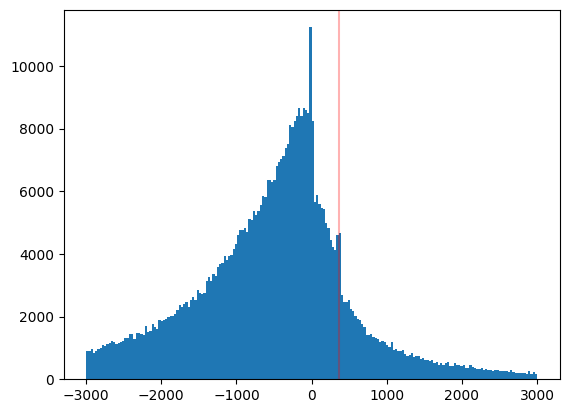

In [58]:
import matplotlib.pyplot as plt
PPPs[PPPs["PPP_score"] > 0]["difference_original_patent_app_paper"].hist(bins = 200)
plt.axvline(x = 367 , color = "red", alpha=0.3)
plt.grid()

plt.show()


## Final file 

In [65]:
PPPs_GK = pd.read_csv(main_path + "/PPPs_GK.tsv" , delimiter = "\t" , index_col = 0)

In [66]:
PPPs_citations = pd.read_csv(main_path + "/PPPs_citations.tsv" , delimiter = "\t" , index_col = 0)
set_PPPs_citations = set(PPPs_citations.index) 

In [67]:
PPPs = pd.concat([ PPPs_GK , PPPs_citations])
PPPs = PPPs.drop_duplicates([ "paper_id" , "patent_id"])

In [68]:
PPPs["citation"] = [ 1 if elem in set_PPPs_citations else 0 for elem in PPPs.index ] 

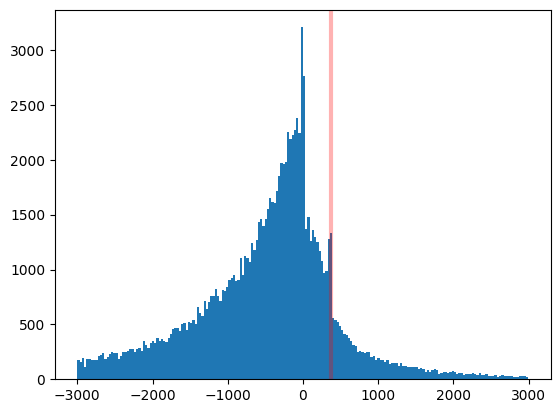

In [19]:
import matplotlib.pyplot as plt
PPPs[PPPs["PPP_score"] == 4]["difference_original_patent_app_paper"].hist(bins = 200)
plt.axvline(x = 367 , color = "red", alpha=0.3,linewidth=3)
plt.grid()

plt.show()


In [71]:
PPPs.to_csv(main_path + "PPPs_v2.tsv" , sep = "\t", index = False )

In [1]:
import pandas as pd
main_path = "/home/fs01/spec1142/Emma/PPPs/"
PPPs = pd.read_csv(main_path + "PPPs_v2.tsv" , delimiter = "\t" )

In [16]:
PPPs

,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,patent_id,...,concepts,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,difference_original_patent_app_paper,all_patents_for_a_same_paper,family,citation
0,1.000000,0.742519,3265,165,article,6,100.000000,1.954428,W4230776453,US-9053919,...,"Physics, Engineering, Chemistry",Highland Community College - Illinois; Brigham...,education,UNIVERSITY,Brigham Young University,0.0,-200,NaN,1296822.0,0
1,0.722387,0.659401,1475,-2220,article,6,46.153846,12.479383,W2133348390,US-7358347,...,"Biology, Medicine",National Cancer Institute; National Institute ...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-2584,NaN,454244.0,0
2,0.654039,0.607773,3774,79,article,13,100.000000,13.030851,W2114546531,US-7358347,...,Biology,University of Toronto; National Institutes of ...,education; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-285,NaN,454244.0,0
3,0.697149,0.610430,3211,-484,article,13,100.000000,12.479383,W2075173469,US-7358347,...,"Biology, Medicine",National Institutes of Health; National Instit...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-848,NaN,454244.0,0
4,0.791079,0.637815,3842,147,article,13,100.000000,11.319638,W2087451891,US-7358347,...,Biology,National Center for Biotechnology Information;...,education; facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-217,NaN,454244.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548310,0.748434,0.607198,1277,313,article,1,50.000000,576.430439,W1598870275,US-5643726,...,"Medicine, Computer science, Chemistry, Biology",Johns Hopkins Medicine; Johns Hopkins University,healthcare; education,UNIVERSITY,The General Hospital Corporation,0.0,313,NaN,334985.0,1
548311,0.437002,0.563353,1735,915,article,4,100.000000,433.324045,W1602494479,US-5759763,...,"Medicine, Biology",National Institute for Minamata Disease; Natio...,education; facility,GOV NON-PROFIT,Director of National Institute of Animal Indus...,0.0,517,NaN,346941.0,1
548312,0.611869,0.551453,5593,2739,article,2,100.000000,5.114189,W1603508604,US-9040297,...,Biology,Technion – Israel Institute of Technology; Heb...,education,UNIVERSITY,TECHNION RESEARCH AND DEVELOPMENT FOUNDATION LTD.,0.0,2036,NaN,1258078.0,1
548313,0.533788,0.510171,2122,165,article,5,100.000000,52.257799,W1618227575,US-7067815,...,"Physics, Computer science, Materials science, ...",University of Bern; Delft University of Techno...,education,GOV NON-PROFIT,Stichting voor de Technische Wetenschappen,0.0,165,NaN,830957.0,1


In [20]:
PPPs[( ( PPPs['difference_patent_grant_paper'] - PPPs['difference_patent_app_paper'] ) >= 10*365 + 1 ) ]

,title_similarity,abstract_similarity,difference_patent_grant_paper,difference_patent_app_paper,paper type,authors in common,proportion inventors,distance_inst_assignee,paper_id,patent_id,...,concepts,paper_institution,paper_institutions,patent_institutions,patent_assignee,assigned_to_individual,difference_original_patent_app_paper,all_patents_for_a_same_paper,family,citation
1,0.722387,0.659401,1475,-2220,article,6,46.153846,12.479383,W2133348390,US-7358347,...,"Biology, Medicine",National Cancer Institute; National Institute ...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-2584,NaN,454244.0,0
2,0.654039,0.607773,3774,79,article,13,100.000000,13.030851,W2114546531,US-7358347,...,Biology,University of Toronto; National Institutes of ...,education; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-285,NaN,454244.0,0
3,0.697149,0.610430,3211,-484,article,13,100.000000,12.479383,W2075173469,US-7358347,...,"Biology, Medicine",National Institutes of Health; National Instit...,facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-848,NaN,454244.0,0
4,0.791079,0.637815,3842,147,article,13,100.000000,11.319638,W2087451891,US-7358347,...,Biology,National Center for Biotechnology Information;...,education; facility; government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-217,NaN,454244.0,0
5,0.789778,0.624891,4049,354,article,13,100.000000,13.030851,W1499100567,US-7358347,...,Biology,National Institutes of Health; National Cancer...,government,GOV NON-PROFIT,"THE UNITED STATES OF AMERICA, AS REPRESENTED B...",0.0,-10,NaN,454244.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547828,0.550341,0.510698,5167,-608,article,2,100.000000,0.895872,W2079115732,US-9897538,...,"Physics, Computer science, Materials science, ...",Massachusetts General Hospital; Harvard Univer...,healthcare; education,UNIVERSITY,The General Hospital Corporation,0.0,-973,NaN,772826.0,1
547874,0.726508,0.527747,2744,-1716,article,2,66.666667,2647.023281,W2096753000,US-9441244,...,Biology,Toronto General Hospital; Nationwide Children'...,healthcare; education,UNIVERSITY,THE REGENTS OF THE UNIVERSITY OF CALIFORNIA,0.0,-2080,"same parent, same abstract",996526.0,1
547907,0.563064,0.616716,4516,690,article,2,66.666667,396.243525,W2109860489,US-8263756,...,"Medicine, Biology",Osaka University,education,COMPANY,Chugai Seiyaku Kabushiki Kaisha,0.0,690,NaN,976356.0,1
548035,0.850144,0.553126,5485,1064,article,2,66.666667,1504.375688,W2163700405,US-7132395,...,Biology,Miles College,education,COMPANY,"POWER PHARMACEUTICALS, LLC",0.0,-1156,same parent,188296.0,1


In [21]:
1-2764/548315

0.9949591019760539

In [19]:
74702/548315

0.13623920556614355